# MNIST + MLP + CNN

In this notebook, we design and train a Multi-Layer Perceptrons (MLP) and a Convolutional Neural Network (CNN) for hand-written digit classification task. We use MNIST dataset that contains 28x28 pixel images of a hand-written digit (0 to 9, so 10 classification targets). 

## Goals
1. Get familiar with MNIST dataset
2. Recap about DataLoader
3. Design MLP and train on MNIST
4. Design CNN and train on MNIST

Let's start with usual import!

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## 1. MNIST Dataset
MNIST is widely used for an introductory machine learning (ML) courses/lectures. Most, if not all, ML libraries provide an easy way (API) to access MNIST and many publicly available dataset. This is true in `pytorch` as well. MNIST dataset in `Dataset` instance is available from `torchvision`. 

A `torchvision` is a supporting module that has many image-related APIs including an interface (and management) of MNIST dataset. Let's see how we can construct:

In [2]:
from torchvision import datasets, transforms
# Data file download directory
LOCAL_DATA_DIR = './mnist-data'
# Use prepared data handler from pytorch (torchvision)
dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

Here, MNIST is also a type `Dataset` (how? through class inheritance). All torch `Dataset` instance have tow useful and common functions: the length representations and data element access via index.

In [3]:
print( len(dataset)  )
print( type(dataset[0]) )

60000
<class 'tuple'>


That being said, how each data element is presented depends on a particular `Dataset` implementation. In case of MNIST, it is a tuple of length 2: **data** and **label**.

Type of data  : <class 'torch.Tensor'> shape torch.Size([1, 28, 28])
Type of label : <class 'int'> value 5


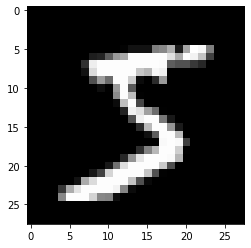

In [4]:
ENTRY=0
data, label = dataset[ENTRY]
print('Type of data  :', type(data),  'shape', data.shape)
print('Type of label :', type(label), 'value', label)

import matplotlib.pyplot as plt
%matplotlib inline

# Draw data
data = data.view(data.shape[1:])
plt.imshow(data,cmap='gray')
plt.show()

## 2. Creating DataLoader
Later (in this notebook), we will try a logistic regression using stochastic gradient descent. For this, we need a capability to randomly select a subset of dataset many times. This part is important: we want to maximize the time spent for training, not reading data and making it available for training.  

Pytorch (and almost all ML libraries) provides a utility to do this so that you don't have to reinvent. This is called `DataLoader`, and here is how you can create.

In [5]:
#from kmi.iotools.collates import MNISTCollate

loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=32,
                                     shuffle=True,
                                     num_workers=4,
                                     pin_memory=False)


#### Details (ignore if wished): `DataLoader` constructor arguments
The first argument is you dataset, and it can be anything but requires two attributes: [`__len__`](https://docs.python.org/3/reference/datamodel.html#object.__len__) and [`__getitem__`](https://docs.python.org/3/reference/datamodel.html#object.__getitem__). In case you wonder, these attributes allow you to call `len(dataset)` and access dataset elements  by `dataset[X]` where `X` is an index integer.

The other constructor arguments used above are:
* `batch_size` ... the same of the subset data to be provided at once
* `shuffle` ... whether or not to randomize the choice of subset dataset (False will provide dataset
* `num_workers` ... number of parallel data-reader processes to be run (for making data read faster using `multiprocessing` module)
* `pin_memory` ... speed up data transfer to GPU by avoiding a necessiry to copy data from pageable memory to page-locked (pinned) memory. Read [here](https://devblogs.nvidia.com/how-optimize-data-transfers-cuda-cc/) for more details. If you are not sure about the details, set to `True` when using GPU. 

## Data streaming with `DataLoader`
So let's play with it! First of all, it has the concept of "length".

In [6]:
print('length of DataLoader:',len(loader))
print('By the way, batch size * length =', 20 * len(loader))

length of DataLoader: 1875
By the way, batch size * length = 37500


We know the data total statistics is 60,000 which coincides with the length of `DataLoader` instance and the batch size where the latter is the unit of batch data. **Yep, as you guessed**, `DataLoader` is iterable: 

In [7]:
# Create an iterator for playin in this notebook
from itertools import cycle
iter = cycle(loader)

for i in range(10):
    batch = next(iter)    
    print('Iteration',i)
    print(batch[1])

Iteration 0
tensor([0, 3, 7, 2, 3, 6, 7, 9, 7, 2, 4, 6, 4, 4, 5, 9, 2, 2, 6, 2, 1, 3, 8, 3,
        8, 6, 0, 8, 7, 5, 5, 7])
Iteration 1
tensor([5, 4, 7, 6, 2, 2, 3, 0, 3, 6, 3, 1, 2, 4, 6, 3, 1, 4, 2, 9, 3, 7, 9, 7,
        7, 6, 3, 9, 9, 4, 9, 6])
Iteration 2
tensor([3, 6, 7, 2, 3, 8, 8, 5, 4, 8, 2, 2, 2, 1, 9, 4, 9, 6, 5, 7, 6, 2, 0, 2,
        4, 4, 4, 5, 6, 7, 8, 5])
Iteration 3
tensor([7, 7, 5, 5, 7, 1, 1, 8, 5, 7, 6, 4, 7, 1, 3, 1, 4, 4, 0, 7, 3, 9, 1, 0,
        1, 2, 3, 6, 0, 2, 4, 5])
Iteration 4
tensor([5, 9, 8, 2, 7, 3, 1, 8, 7, 7, 1, 2, 8, 8, 9, 9, 5, 9, 2, 3, 8, 2, 5, 9,
        4, 2, 2, 9, 7, 7, 1, 6])
Iteration 5
tensor([3, 4, 6, 8, 2, 9, 9, 4, 1, 4, 9, 4, 5, 9, 1, 2, 7, 4, 6, 5, 1, 6, 5, 9,
        8, 9, 6, 7, 7, 2, 2, 1])
Iteration 6
tensor([9, 4, 2, 9, 9, 9, 0, 9, 6, 1, 8, 4, 3, 4, 0, 9, 6, 9, 9, 2, 2, 5, 6, 1,
        6, 9, 2, 6, 6, 6, 3, 6])
Iteration 7
tensor([7, 8, 9, 6, 1, 3, 4, 6, 4, 6, 6, 7, 5, 7, 0, 9, 1, 8, 6, 6, 9, 1, 1, 3,
        4, 9, 4, 4, 5, 6, 1, 6])


... and this is how `data` looks like:

In [8]:
print('Shape of an image batch data',batch[0].shape)

Shape of an image batch data torch.Size([32, 1, 28, 28])


... which is quite naturally 20 of 28x28 image

## 3. Logistic regression with MLP

Let's try a logistic regression on this MNIST dataset. 

### Model definition
We follow a similar approach we have taken in the previous notebook where we tried a logistic regression using 2-layers MLP with LeakyReLU activation function between two layers.  


In [9]:
class MLP(torch.nn.Module):
    def __init__(self, num_filters=16):
        
        super(MLP, self).__init__()
        # MLP w/ 2 hidden layers, 128 neurons each
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(28*28, num_filters), 
            torch.nn.LeakyReLU(),
            torch.nn.Linear(num_filters,10)
        )

    def forward(self, x):
        # Make 2d image into 1D array
        x_1d = x.view(-1, np.prod(x.size()[1:]))
        return self._classifier(x_1d)


### Train loop function
Next, let's define a train loop function. This is also mostly copy-and-paste from the previous notebook. A small modification include an option to specify gpu v.s. cpu mode.

In [10]:
def train_torch(data_loader, model, num_iterations=100, lr=0.001, optimizer='SGD', gpu=False):
    # Create a Binary-Cross-Entropy (BCE) loss module
    criterion = torch.nn.CrossEntropyLoss()
    # Create an optimizer
    optimizer = getattr(torch.optim,optimizer)(model.parameters(),lr=lr)
    # Now we run the training!
    loss_v=[]
    while num_iterations > 0:
        for data,label in data_loader:
            
            if gpu:
                data,label = data.cuda(),label.cuda()
            # Prediction
            prediction = model(data)
            # Compute loss
            loss = criterion(prediction, label)
            # Update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Record loss
            loss_v.append(loss.item())
            # Brake if we consumed all iteration counts
            num_iterations -= 1
            if num_iterations < 1:
                break
        
    return np.array(loss_v)

### Train!

Let's train for 4000 steps using Adam optimizer. Also, the number of filters is default = 16.

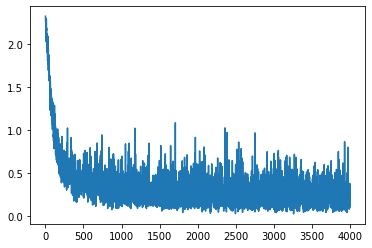

In [11]:
model_a = MLP()

loss = train_torch(loader, model_a, 4000, optimizer='Adam')

plt.plot(loss)


That is a pretty large fluctuation! Often it's useful to look at a moothed loss curve by taking an average value with the neighbor data points. Let's try this.

In [12]:
# Compute moving average
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

last 20 average 0.21011923551559447


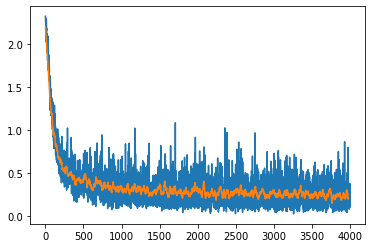

In [13]:
plt.plot(loss)
plt.plot(moving_average(loss,20))
print('last 20 average',np.mean(loss[-20:]))

### Exercise 1

1. Repeat the same training for `model_b` = `MLP` with 32 filters. 
2. Plot the loss curve with 20 neighbor-points average.
3. Compare the los value of the last 20 steps against the `model_a`. 

last 20 average 0.21024020202457905


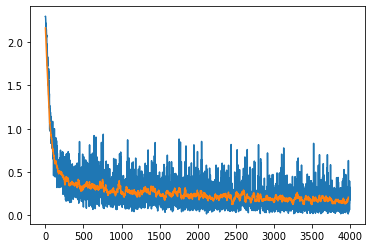

In [14]:
# your code here

### Exercise 2

1. Repeat the exercise 1 and measure how long it takes in wall-time.
2. Repeat again, but this time with GPU enabled, and measure how long it takes.

You probably see a very similar amount of time taken for both cases. This is because parallelizable fraction of computation is not dominating in the overall computing time (and especially when most time may be taken to copy data onto gpu).

In [15]:
# your code here

With GPU 15.420133113861084
With CPU 17.030401945114136


### Running on test dataset
Both models seem to be trained OK. Let's benchmark their performance using the test dataset! Pytorch provides 10,000 MNIST dataset that is separate from the training set by simply setting the flag `train=False`.

In [16]:
# Use prepared data handler from pytorch (torchvision)
test_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=False, download=True,
                              transform=transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=32,
                                          shuffle=False,
                                          num_workers=4,
                                          pin_memory=False)

### Inference loop function

Let's now write a function to run the inference. This would be similar to the training loop. A key difference is to use a scope `with torch.set_grad_enabled(False)` which disables gradient calculation and caching of intermediate data for it. This results in less memory usage, so you should do this when you run your model for inference and not training.

In [17]:
def run_test(model,loader,gpu=False):

    from scipy.special import softmax

    prediction_v = []
    label_v      = []
    softmax_v    = []
    
    with torch.set_grad_enabled(False):
        idx=0
        for data,label in loader:
            if gpu:
                data,label = data.cuda(), label.cuda()
            prediction   = model(data).cpu().numpy()
            prediction_v.append ( np.argmax(prediction,axis=1)    )
            label_v.append      ( label.cpu().numpy().reshape(-1) )
            s = softmax(prediction,axis=1)
            softmax_v.append    (s)
            idx +=1
    return np.concatenate(prediction_v), np.concatenate(label_v), np.concatenate(softmax_v)

### Exercise 3
1. Run the inference for `model_a` and `model_b`.
2. Using the results, compute the accuracy over the whole test dataset for both models.

In [18]:
# your code here

model_a 0.9321
model_b 0.9444


### Exercise 4

1. Count the number of parameters in our `model_a`
2. How about `model_b`?


In [19]:
# your code here

model_a 12730 parameters
model_b 25450 parameters


## 4. Logistic regression with CNN

Next, we design CNN to try the same task. Let's define 3 convolution layers followed by LeakyReLU for activation and MaxPool2d for downsampling.

In [20]:
class CNN(torch.nn.Module):
    def __init__(self,num_filters=16):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1,num_filters,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(num_filters,num_filters*2,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(num_filters*2,num_filters*4,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(7,7))
        # classifier MLP
        self._classifier = torch.nn.Linear(num_filters*4,10)

    def forward(self, x):
        # extract features
        features = self._feature_extractor(x)
        # flatten the 3d tensor (2d space x channels = features)
        features = features.view(-1, np.prod(features.size()[1:]))
        # classify and return
        return self._classifier(features)

### Exercise 5

Now let's train this CNN model!

1. Train CNN for 4000 iterations with `Adam` optimizer on CPU, measure the time taken in wall-clock, plot the loss.
2. Do the same but using GPU.


CPU: 86.25612664222717 [s]
GPU: 17.39392590522766 [s]
last 20 average 0.05249731121584773


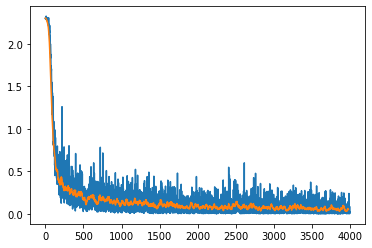

In [21]:
# your code here

You should see that, this time, GPU gave a good speed-up. This is because CNN takes many separate multiplications of weights with input local matrix, and that can benefit from parallelization = GPU is suited.

### Exercise 6

Run the inference on the test dataset. Compute the accuracy over the all images in the test dataset.

In [22]:
# your code here

model_c 0.987


### Exercise 7
How many parameters are there in our CNN model?

In [23]:
# your code here

23946
